In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

## Query data

In [3]:
def query_graph(uri: str, query: str) -> dict:
    request = requests.post(uri, json={'query': query})
    if request.status_code >= 200 and request.status_code <= 299:
        return request.json()
    else:
        raise Exception(f"Failed HTTP Post request with status: {request.status_code}")

### Repuation Holders
First query all reputation holders and filter by organization to get dOrg members

In [4]:
def queryAllRepHolders() -> list:
    result = []
    url = 'https://api.thegraph.com/subgraphs/name/daostack/alchemy'
    skip = 0
    query = '{{ \n \
      reputationHolders(first: 1000, skip:{skip}) {{ \n \
        address \n \
        balance \n \
        dao {{ \n \
          name \n \
        }} \n \
        createdAt \n \
      }} \n \
    }}'
    response = query_graph(url, query.format(skip=skip))
    while len(response['data']['reputationHolders']) > 0:
        result += response['data']['reputationHolders']
        skip += 1000
        response = query_graph(url, query.format(skip=skip))
    return result

In [5]:
response_reputation_holders = queryAllRepHolders()

In [6]:
def clean_rep_holders_data(df, dao_name):
    # filter by dao
    undict = lambda x: x['name']
    df['dao'] = df['dao'].apply(undict)
    df = df[df.dao == dao_name].reset_index()
    
    # set data types
    df['address'] = df['address'].astype('string')
    df['balance'] = df['balance'].astype('string')
    df['createdAt'] = df['createdAt'].apply(int).astype('datetime64[s]')
    df['dao'] = df['dao'].astype('string')
    
    # handle uint64 overflow -> units now in quadrillions
    # first count and truncate final 15 (or fewer) digits
    units_fn = lambda x: min(len(x), 15)
    df['units'] = df['balance'].apply(units_fn)
    truncate = lambda x: x[0:len(x)-15] if len(x) > 15 else len(x)
    df['balance_quadrillions'] = df['balance'].apply(truncate).astype('string').astype('float64')
    # log and recombine
    df['log10_balance'] = np.log10(df.balance_quadrillions) + df.units
    
    return df

In [7]:
reputation_holders = pd.DataFrame(response_reputation_holders)
reputation_holders = clean_rep_holders_data(reputation_holders, 'dOrg')

In [8]:
reputation_holders

,index,address,balance,createdAt,dao,units,balance_quadrillions,log10_balance
0,85,0x5db06acd673531218b10430ba6de9b69913ad545,80840000000000000000,2020-02-12 00:33:04,dOrg,15,80840.0,19.907626
1,210,0x3e9976d5ba86a78d6e5c25bc2f309049676c0798,24633000000000000000,2019-06-11 17:24:35,dOrg,15,24633.0,19.391517
2,217,0xc6ee47385c205139612a4f847a067bfcdc59df54,113114999999999998437,2019-11-09 14:15:36,dOrg,15,113114.0,20.053516
3,284,0x0a0b5fe27b2f4be657ee91c48af4ceeae097706e,48340000000000000746,2019-12-02 15:46:59,dOrg,15,48340.0,19.684307
4,450,0x1338c277e03fbe9d6b1b3b655f0e567c0dcaac4a,1428000000000000000000,2020-02-12 20:38:05,dOrg,15,1428000.0,21.154728
...,...,...,...,...,...,...,...,...
86,6426,0x3e9976d5ba86a78d6e5c25bc2f309049676c0798,4926000000000000000000,2020-02-12 20:38:05,dOrg,15,4926000.0,21.692494
87,6444,0x1f134294dee0055da2a9914f73d2a7a59d374ac0,2200000000000000000000,2020-02-12 20:38:05,dOrg,15,2200000.0,21.342423
88,6547,0x5b52ba08252f17a1560b8f6bdf025518d18b6a62,4050000000000000000000,2020-03-06 05:32:31,dOrg,15,4050000.0,21.607455
89,6563,0xbeeb66591fc66210672880da41a481bf9fcfc72a,18372000000000000000000,2020-02-12 20:38:05,dOrg,15,18372000.0,22.264156


In [9]:
reputation_holders.dtypes

index                            int64
address                         string
balance                         string
createdAt               datetime64[ns]
dao                             string
units                            int64
balance_quadrillions           float64
log10_balance                  float64
dtype: object

### Repuation Transactions

In [222]:
def queryBlockRepTransactions(table: str, block=10718611) -> list:
    result = []
    url = 'https://api.thegraph.com/subgraphs/name/daostack/alchemy'
    skip = 0
    query = '{{ \n \
        {table} (first: 1000, block: {{ number: {block} }}, skip: {skip}) {{ \n \
        id \n \
        txHash \n \
        contract \n \
        address \n \
        amount \n \
      }} \n \
    }}'
    response = query_graph(url, query.format(table=table, block=block, skip=skip))
    while len(response['data'][table]) > 0:
        result += response['data'][table]
        skip += 1000
        response = query_graph(url, query.format(table=table, block=block, skip=skip))
    return result

In [223]:
def queryAllRepTransactions(table: str, newest_block: int, address_whitelist=None):
    result = pd.DataFrame()
    block = newest_block
    response = queryBlockRepTransactions(table, block)
    while len(response) > 0 and block > 10718611-50:
        # add to result
        response_df = pd.DataFrame(response)
        if address_whitelist is not None:
            response_df = [response_df.address.isin(address_whitelist)]
        response_df['block'] = block
        result = result.append(response_df)
        result = result.drop_duplicates(subset=['id', 'txHash', 'contract', 'address', 'amount'], keep='first')
        # query next block
        block -= 1
        response = queryBlockRepTransactions(table, block)
    result.reset_index(inplace=True)
    return result

In [225]:
#response_reputation_mints = queryBlockRepTransactions('reputationMints')

In [229]:
#reputation_mints = pd.DataFrame(response_reputation_mints)
#reputation_mints

,address,amount,contract,id,txHash
0,0x0ebbda43014a6e6c32657a8db79376738d549b2f,57686312682801532550,0x30412f4c06343d65c06b5a0bba6821cf37e605fa,0x0002a6074543687338a3de9f9a53e3382667334009cd...,0x48e571535ed433e45c0d8a49c2d5afa62f1832f95c6c...
1,0x3f0b2a18b6da197c8c0744918febc7dcddab0e04,30000000000000000000,0xed1c0bb038b370a16242f077899ee1e5e7d6add1,0x0008dbd90effb817853281b7ce592fff48a35e7aaf89...,0xb705eeb2b9cd9de888662901dfaf1d50f083e5fbda73...
2,0x81aaa9a7a8358cc2971b9b8de72acce6d7862bc8,50000000000000000000,0x30412f4c06343d65c06b5a0bba6821cf37e605fa,0x000e69e1ef68b56fb5ce1870291b5dfc9882ffd73420...,0x7a1da0b3d9c7a6cbb4cc73545fd8281bd64f517cdb85...
3,0xb9e29984fe50602e7a619662ebed4f90d93824c7,130000000000000000000,0xed1c0bb038b370a16242f077899ee1e5e7d6add1,0x001617af3e786cbc864c8fa938ed74cae8a4bc8ea7cb...,0x629a7a3b6c70552a7f1e711841aae2ab6627e5ebf73e...
4,0xb7bdb99abbddebba1d5802c0f4e5073f1a75a9ea,10000000000000000000,0xed1c0bb038b370a16242f077899ee1e5e7d6add1,0x0022f022c026f08e5f70c2cc9362507cdceddbc9ddef...,0xdc26e17fe7fef5fdceacbe08f06b8f440efadbbc191c...
...,...,...,...,...,...
9998,0x24597c5c68687e816ffc0c69e064cb70bb62a9cd,33312912412375480946,0x30412f4c06343d65c06b5a0bba6821cf37e605fa,0xffce060627e5e8bc25132eabcc5c2d3ce9834b933fb4...,0x28a6601382fd0cfe83d11876159f5ebaaffa2a8a5e46...
9999,0x30043aabbcebbd887437ec4f0cfe6d4c0eb5cc64,5794387245460010576,0x30412f4c06343d65c06b5a0bba6821cf37e605fa,0xffd282038b45de10e3c64f1ca9d15c20204a441286aa...,0x8b026c10ea6f2cf9f3f562ea7a3ab707d24c17b46cb7...
10000,0x1206ec7abf2c3d22051f6ebb249f065fc6436149,50000000000000000000,0x30412f4c06343d65c06b5a0bba6821cf37e605fa,0xffd664c72f814a7f80cee8f3c9373870e8ccd4c8ee4f...,0x82d919691c45dc59817ea2a69600cc6e62ee340e55e8...
10001,0x19cec11d268d61305e53524a55f8e94733c98d96,50000000000000000000,0xed1c0bb038b370a16242f077899ee1e5e7d6add1,0xffeddfe5fa020576815656f804fc8ac0de3313b2a9ee...,0x0a54643070242ff667d37908a31cc5ee3cc3c68e2d71...


## Static Visualizations

In [10]:
# O(N) implementation of gini coefficient found at: 
# https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python/48999797#48999797
def gini(x, w=None):
    # Array indexing requires reset indexes.
    x = pd.Series(x).reset_index(drop=True)
    if w is None:
        w = np.ones_like(x)
    w = pd.Series(w).reset_index(drop=True)
    n = x.size
    wxsum = sum(w * x)
    wsum = sum(w)
    sxw = np.argsort(x)
    sx = x[sxw] * w[sxw]
    sw = w[sxw]
    pxi = np.cumsum(sx) / wxsum
    pci = np.cumsum(sw) / wsum
    g = 0.0
    for i in np.arange(1, n):
        g = g + pxi.iloc[i] * pci.iloc[i - 1] - pci.iloc[i] * pxi.iloc[i - 1]
    return g

In [11]:
# O(N^2)
# https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

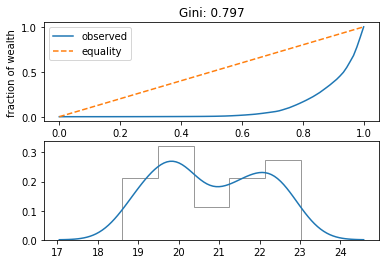

In [38]:
reputation_holders.sort_values('balance_quadrillions', ascending=True, inplace=True)
vals = reputation_holders.balance_quadrillions.values
gini_coef = gini(vals)
y = vals.cumsum() / vals.sum()
x = np.arange(vals.size) / (vals.size - 1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, y, label='observed')
plt.plot(x, x, '--', label='equality')
plt.xlabel('fraction of population')
plt.ylabel('fraction of wealth')
plt.title(f'Gini: {gini_coef:.3f}')
plt.legend()
plt.subplot(2, 1, 2)
sb.distplot(reputation_holders.log10_balance.values, hist_kws={'histtype': 'step', 'color': 'black'})
plt.show()